In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import random
import os
from keras.applications import vgg16
from keras import Model
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from keras.models import model_from_json
import cv2

In [2]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode = "nearest",
    preprocessing_function = preprocess_input,
    validation_split=0.25
    )

In [3]:
train_generator = train_datagen.flow_from_directory(
    directory=r"C:\\Face Mask Detection -Completed\\Dataset\\",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset='training'
)

Found 8284 images belonging to 3 classes.


In [4]:
train_generator[0]

(array([[[[-0.681679  , -0.6660569 , -0.6387664 ],
          [-0.718124  , -0.6990309 , -0.66306305],
          [-0.75456893, -0.73200494, -0.6873597 ],
          ...,
          [-0.7088629 , -0.65396094, -0.42839205],
          [-0.70980394, -0.654902  , -0.42745095],
          [-0.69007224, -0.6417475 , -0.3879876 ]],
 
         [[-0.53423774, -0.52925384, -0.5299884 ],
          [-0.57415366, -0.5674343 , -0.5629624 ],
          [-0.6128462 , -0.6037796 , -0.59287786],
          ...,
          [-0.70980394, -0.654902  , -0.42745095],
          [-0.70853806, -0.6540581 , -0.4249193 ],
          [-0.6862745 , -0.6392157 , -0.38039213]],
 
         [[-0.41960782, -0.41960782, -0.4352941 ],
          [-0.41960782, -0.41960782, -0.4352941 ],
          [-0.4588495 , -0.4571433 , -0.46771115],
          ...,
          [-0.70980394, -0.654902  , -0.42745095],
          [-0.70396173, -0.6510072 , -0.41576666],
          [-0.6862745 , -0.6392157 , -0.38039213]],
 
         ...,
 
         [[ 

In [5]:
valid_generator = train_datagen.flow_from_directory(
    directory=r"C:\\Face Mask Detection -Completed\\Dataset\\",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 2760 images belonging to 3 classes.


In [6]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [7]:
base_model = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
x = base_model.output
x = AveragePooling2D(pool_size=(7,7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation='relu')(x)        
x = Dropout(0.5)(x) 
predictions = Dense(3, activation = 'softmax')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [10]:
#early stop 
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [11]:
#modelcheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('C:\\Users\\253336\\Desktop\\temp-facemask\\FaceMask.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

C:\Users\253336\AppData\Local\Temp\ipykernel_11648\266005463.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_generator,


Epoch 1/5
258/258 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.6569
Epoch 1: val_accuracy improved from -inf to 0.63590, saving model to C:\Users\253336\Desktop\temp-facemask\FaceMask.h5
258/258 [==============================] - 500s 2s/step - loss: 0.6515 - accuracy: 0.6569 - val_loss: 0.6022 - val_accuracy: 0.6359
Epoch 2/5
258/258 [==============================] - ETA: 0s - loss: 0.5125 - accuracy: 0.6928
Epoch 2: val_accuracy improved from 0.63590 to 0.64571, saving model to C:\Users\253336\Desktop\temp-facemask\FaceMask.h5
258/258 [==============================] - 417s 2s/step - loss: 0.5125 - accuracy: 0.6928 - val_loss: 0.5677 - val_accuracy: 0.6457
Epoch 3/5
258/258 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.7059
Epoch 3: val_accuracy did not improve from 0.64571
258/258 [==============================] - 387s 1s/step - loss: 0.4867 - accuracy: 0.7059 - val_loss: 0.5570 - val_accuracy: 0.6352
Epoch 4/5
258/258 [========

C:\Users\253336\AppData\Local\Temp\ipykernel_11648\266005463.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)


Score [0.550427258014679, 0.6391715407371521]


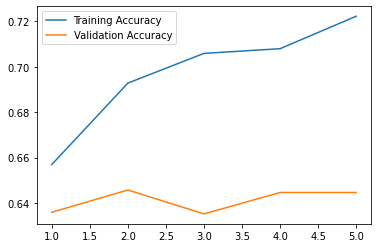

In [12]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15, #can change
                    callbacks=[es,mc])
score = model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)
print("Score", score)

epoch_list = list(range(1, len(hist.history['accuracy']) + 1)) 
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

In [13]:
#load the saved model 
from tensorflow.keras.models import load_model
saved_model=load_model('C:\\Users\\253336\\Desktop\\temp-facemask\\FaceMask.h5')
# evaluate only the saved model
_, train_acc = saved_model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)
_, test_acc = saved_model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

C:\Users\253336\AppData\Local\Temp\ipykernel_11648\1831680101.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, train_acc = saved_model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)
C:\Users\253336\AppData\Local\Temp\ipykernel_11648\1831680101.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, test_acc = saved_model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)


Train: 0.644, Test: 0.648


In [14]:
#save the model with maximum value accuracy
saved_model.save('C:\\Users\\253336\\Desktop\\temp-facemask\\FaceMask.model')

INFO:tensorflow:Assets written to: C:\Users\253336\Desktop\temp-facemask\FaceMask.model\assets


INFO:tensorflow:Assets written to: C:\Users\253336\Desktop\temp-facemask\FaceMask.model\assets


# Detect the RealTime Video data

In [1]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from scipy.spatial import distance
from math import pow, sqrt
import numpy as np
import imutils
import time
import cv2
import os
import time
import winsound
import warnings
frequency = 2500
duration = 1000

In [2]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), #preprocessing function
		(104.0, 177.0, 123.0))

		#The blobFromImage function performs
			# Mean subtraction
			# Scaling
			# normalizing
			# And optionally channel swapping

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []
	#positions = []
	boxes=[]

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with the detection
		confidence = detections[0, 0, i, 2]

# filter out weak detections by ensuring the confidence is greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			faces.append(face)
			locs.append((startX, startY, endX, endY))
			#positions.append((centroid_x_centimeters, centroid_y_centimeters, distance))

			#new social distancing code
			centerX = (endX + startX)/2
			centerY = (endY + startY)/2
			width = endX-startX
			height = endY-startY

			x = int(centerX - (width/2))
			y = int(centerY - (height/2))

			box_centers = [centerX, centerY]

			boxes.append([x, y, int(width), int(height)])



	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
	
	# social distance code
	min_distance = 2 #2000

	sodists = [0 for i in range(len(faces))]
	if len(faces) >= 9:          #instead 2
		for i in range(len(faces)-1):
			for j in range(i+1,len(faces)):
				dist = sqrt(pow(positions[i][0]-positions[j][0],2) 
                                          + pow(positions[i][1]-positions[j][1],2) 
                                          + pow(positions[i][2]-positions[j][2],2)
                                          )
				#dist = distance.euclidean(locs[i][:2],locs[j][:2])
				if dist < min_distance:
					sodists[i]=1
					sodists[j]=1

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds, sodists)

In [3]:
# load our serialized face detector model from disk
prototxtPath = r"C:\\Users\\253336\\Desktop\\Completed Face Mask Detection -Done\\deploy.prototxt" 
weightsPath = r"C:\\Users\\253336\Desktop\\Completed Face Mask Detection -Done\\res10_300x300_ssd_iter_140000.caffemodel" 
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

In [4]:
# load the face mask detector model from disk
maskNet = load_model("C:\\Users\\253336\Desktop\\Completed Face Mask Detection -Done\\MaskDetectionModel.model")

In [5]:
# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	#frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a face mask or not
	(locs, preds, sodists) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred, sodist) in zip(locs, preds, sodists):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(incorrectMask, mask, withoutMask) = pred #(changed code)


		# determine the class label and color we'll use to draw
		# the bounding box and text

		#(the following part is changed to show the 3rd class incorrect Mask)
		if (mask > withoutMask) and (mask >incorrectMask):
			label = "Mask"
		elif (withoutMask>mask) and (withoutMask>incorrectMask):
			label = "No Mask"
		elif (incorrectMask > withoutMask) and (incorrectMask>mask):
			label = "Incorrectly Worn Mask"
		
		if label == "Mask":
			color = (0, 255, 0)
		elif label == "No Mask":
			color = (0, 0, 255)
			winsound.Beep(frequency,duration)
		else:
			color = (255, 0, 0) #can change the colour for incorrectMask here 
			winsound.Beep(frequency,duration)
		
		if sodist ==1:
			colordist = (0, 0, 255)
			labeldist = "Less than 2m"
		elif sodist ==0:
			colordist = (0, 255, 0)
			labeldist = "" 
        

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(incorrectMask, mask, withoutMask) * 100) #(changed code)

		# display the label and bounding box rectangle on the output
		# frame

		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
        # display the label and bounding box rectangle on the output (for social distancing)
		# frame
		cv2.putText(frame, labeldist, (startX-20, startY - 30),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, colordist, 2)
		cv2.rectangle(frame, (startX-20, startY-20), (endX+20, endY+20), colordist, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(10) & 0xFF  #waitKey(1)

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
(1, 1, 200, 7)
1/1 [==============================] - 2s 2s/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 74ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 97ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 59ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 66ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 59ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 57ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 65ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 59ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 58ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 63ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 59ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 59ms/step
(1, 1, 200, 7)
1/1 [==============================] - 0s 63ms/step
(1, 1, 200, 7)
1/1 [============

KeyboardInterrupt: 